In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from dataclasses import dataclass
from transformers import get_scheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.decomposition import PCA
import numpy as np

In [ ]:
@dataclass
class Output:
    logits: None
    total_loss: None

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_dim = 16

In [ ]:
class clustering(nn.Module):
    def __init__(self, num_cluster):
        super().__init__()
        self.centroids = nn.Parameter(3*torch.randn(num_cluster, num_dim, requires_grad=True))
        
    def forward(self, x):
        logits = torch.norm(x.unsqueeze(1)-self.centroids, dim = -1)
        i_argmin = torch.argmin(logits, dim=-1)
        total_loss = torch.sum(logits.gather(1, i_argmin.unsqueeze(1)))
        return Output(logits=logits, total_loss=total_loss)

In [ ]:
# A = np.array([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#               [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
#               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
#               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])
# def gen_data(A, sigma_x = 0.5, num_object = 100):
#     num_feature, num_dim = A.shape
#     I = sigma_x*np.ones(num_dim)
#     Z = np.zeros((num_object, num_feature))
#     X = np.zeros((num_object, num_dim))
#     for i in range(num_object):
#         while (Z[i,:].sum() == 0):
#             Z[i,:] = np.random.rand(1,num_feature) > .5
#         X[i,:] = np.random.randn(num_dim)*I+Z[i,:]@A
#     return X, Z



In [ ]:
def gen_data(N, num_clusters=5, num_dim=num_dim):
    cat = []
    for i in range(num_clusters):
        cat.append(torch.randn(1, num_dim) + torch.randn(N, num_dim))
    return torch.cat(cat, dim=0)

In [ ]:
X = gen_data(1600, 3, num_dim)

In [ ]:
train_set = TensorDataset(X)
train_loader = DataLoader(train_set, batch_size = 32)

In [ ]:
num_cluster = 10
num_epochs = 30
warmup_ratio = 0.1
num_training_steps = len(train_loader)
lr = 1e-3

model = clustering(num_cluster)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*num_epochs*num_training_steps),
                            num_training_steps=num_epochs*num_training_steps)

losses = []
for i_epoch in trange(num_epochs):
    for i_iter, batch in enumerate(train_loader):
        output = model(batch[0])
        loss = output.total_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.detach().item())

  0%|          | 0/30 [00:00<?, ?it/s]

[<matplotlib.lines.Line2D>]

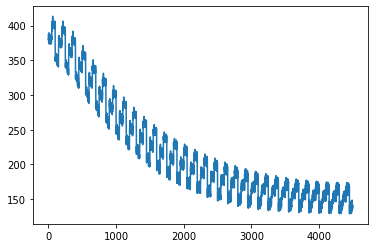

In [ ]:
plt.plot(losses)

In [ ]:
model.eval()
pred = []
for i_iter, batch in enumerate(train_loader):
    output = model(batch[0])
    logits = output.logits
    pred.append(logits.argmin(dim=-1).numpy())
pred = np.concatenate(pred, axis=0)

In [ ]:
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X)

<matplotlib.legend.Legend>

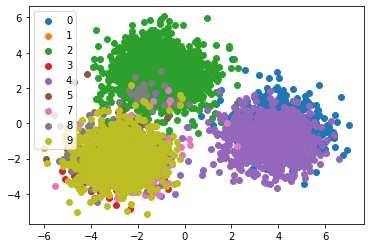

In [ ]:
for i_label in np.unique(pred):
    idx = pred == i_label
    plt.scatter(X_proj[idx,0], X_proj[idx,1], label = f'{i_label}')
plt.legend()